
### Interaction Analysis with Apple Watch Data

### This is a jupyter notebook document and does not require running the code.

The data that consists of motion (acceleration), heart rate and steps was collected using Apple Watch and labeled sleep recorded from polysomnography (0-5, wake = 0, N1 = 1, N2 = 2, N3 = 3, REM = 5) for 31 participants during 7 to 14 days period. Date is recorded in seconds since PSG start.

# 1. Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import time
import re
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
import scipy.stats

# 2. Data and preprocessing
The data is found in a folder, which includes four folders. Each folder (labeled as motion, steps, heart_rate, and labels) includes .txt files for all the subjects. Let us find the directory and download the data. 

The data is very high-resolution, so we want to downsample the data. We will do that by binning the data into 10 minute intervals. This ensures that we have as small intervals as possible to see the variations in the data, while having large intervals to make the data handling easier.

The Heart Beat data is divided into 10 min intervals and for each subject we will take the average heart beat within that interval and that will be the heartbeat for that 10 min interval. 

The steps data we will also take the average of the 10 min interval.

For the Label data we will not take the average, but the most prevalent sleep stage as the prominent Stage within the 10 min interval. I will also substitute the -1 labels with 0.

For the Motion data, we will also take the average of that 10 min interval.

Let us start with the Heart Rate data.

## 2.1 Heart rate data

In [2]:
import os

current_directory = os.getcwd() # get current directory
project_data_path = current_directory + "/project-data/data" # path to the data folder

In [3]:
heart_rate_data = project_data_path + "/heart_rate" # path to heart rate data

id_pattern = re.compile(r'(\d+)')
column_names = ["Minutes", "HeartRate"]

# Define the time intervals
time_intervals = list(range(-604200, 30000, 600)) # for storing the data, 10 min intervals starting from 10070 and the last one at 620
result_dict = {} # format: {ID : {10 minute intervals as keys : corresponding measures as values}}

# Iterate through each text file in the subfolder

for file_name in os.listdir(heart_rate_data):
    file_path = os.path.join(heart_rate_data, file_name)
    # Check if it's a text file
    if file_name.endswith('.txt'):
        # Read the text file into a DataFrame
        heart_rate_df = pd.read_csv(file_path, delimiter=',', names=column_names) 

        # Extract subject ID from the filename using regular expressions
        match = id_pattern.search(file_name)
        if match:
            subject_id = int(match.group())
            # Add a new column 'ID' with the extracted ID to the DataFrame
            heart_rate_df['ID'] = subject_id
                    
        # Create a dictionary for the current subject
        subject_dict = {}
        # Iterate through time intervals
        for interval_start in time_intervals:
            interval_end = interval_start + 600

            # Filter data within the current interval
            filtered_data = heart_rate_df[(heart_rate_df['Minutes'] >= interval_start) & (heart_rate_df['Minutes'] < interval_end)]
            # Calculate the average heart rate within the interval
            average_heart_rate = filtered_data['HeartRate'].mean()

            if pd.isna(average_heart_rate): # If heart rate is not defined, set as 0
                average_heart_rate = 0

            # Assign the average heart rate to the dictionary
            subject_dict[int(interval_start/60)] = average_heart_rate

        # Assign the subject dictionary to the result dictionary
        result_dict[subject_id] = subject_dict
        
# Create a DataFrame from the result_dict
df_heart = pd.DataFrame.from_dict(result_dict, orient='index')

# Reshape the DataFrame so that Date becomes the index and columns are ID and HeartRate
df_heart = df_heart.stack().reset_index(level=1)
df_heart.columns = ['Minutes', 'HeartRate']

df_heart.reset_index(inplace=True)
df_heart.rename(columns={'index': 'ID'}, inplace=True)


# Check for missing values
print(f"Missing values:\n{df_heart.isnull().sum(axis = 0)}")
print("Shape: ", df_heart.shape)
df_heart.head()

Missing values:
ID           0
Minutes      0
HeartRate    0
dtype: int64
Shape:  (32767, 3)


,ID,Minutes,HeartRate
0,8000685,-10070,0.0
1,8000685,-10060,0.0
2,8000685,-10050,0.0
3,8000685,-10040,0.0
4,8000685,-10030,0.0


## 2.2 Labels

In [8]:
labels_data = project_data_path + "/labels"

id_pattern = re.compile(r'(\d+)')
column_names = ["Minutes", "Stage"]

# Define the time intervals
time_intervals = list(range(-604200, 30000, 600)) # for storing the data, 10 min intervals starting from 10070 and the last one at 620
result_dict = {} # format: {ID : {10 minute intervals as keys : corresponding measures as values}}

# Iterate through each text file in the subfolder
for file_name in os.listdir(labels_data):
    file_path = os.path.join(labels_data, file_name)
    
    # Check if it's a text file
    if file_name.endswith('.txt'):
        # Read the text file into a DataFrame
        labels_df = pd.read_csv(file_path, delimiter=' ', names=column_names) 

        # Extract subject ID from the filename using regular expressions
        match = id_pattern.search(file_name)
        if match:
            subject_id = int(match.group())
            # Add a new column 'ID' with the extracted ID to the DataFrame
            labels_df['ID'] = subject_id
            
        labels_df.replace(-1, 0, inplace=True) # replace -1 labels with 0

        # Create a dictionary for the current subject
        subject_dict = {}

        # Iterate through time intervals
        for interval_start in time_intervals:
            interval_end = interval_start + 600

            if interval_start >= 0:

                # Filter data within the current interval
                filtered_data = labels_df[(labels_df['Minutes'] >= interval_start) & (labels_df['Minutes'] < interval_end)]


                # Calculate the most prevalent stage within the interval
                stage_counts = filtered_data['Stage'].value_counts()

                # Choose the first value in case of a tie
                stage = stage_counts.idxmax() if not stage_counts.empty else 0

            else:
                stage = 0

            # Assign the stage to the dictionary
            subject_dict[int(interval_start/60)] = stage
            
        # Assign the subject dictionary to the result dictionary
        result_dict[subject_id] = subject_dict

# Create a DataFrame from the result_dict
df_labels = pd.DataFrame.from_dict(result_dict, orient='index')

# Reshape the DataFrame 
df_labels = df_labels.stack().reset_index(level=1)
df_labels.columns = ['Minutes', 'Stage']

# Reset the index to make Date a regular column
df_labels.reset_index(inplace=True)
df_labels.rename(columns={'index': 'ID'}, inplace=True)

# Check shape
print("Shape: ", df_labels.shape)

# Check for missing values
print(f"Missing values:\n{df_labels.isnull().sum(axis = 0)}")

# Checking there are no -1 values
has_minus_one = (df_labels == -1).any().any()

if has_minus_one:
    print("There are -1 values in the DataFrame.")
else:
    print("There are no -1 values in the DataFrame.")

df_labels.head()

Shape:  (32767, 3)
Missing values:
ID         0
Minutes    0
Stage      0
dtype: int64
There are no -1 values in the DataFrame.


,ID,Minutes,Stage
0,4426783,-10070,0
1,4426783,-10060,0
2,4426783,-10050,0
3,4426783,-10040,0
4,4426783,-10030,0


## 2.3 Steps


In [9]:
steps_data = project_data_path + "/steps"

id_pattern = re.compile(r'(\d+)')
folder_data_frames_steps = []
column_names = ["Minutes", "Steps"]

# Define the time intervals
time_intervals = list(range(-604200, 30000, 600)) # for storing the data, 10 min intervals starting from 10070 and the last one at 620
result_dict = {} # format: {ID : {10 minute intervals as keys : corresponding measures as values}}


# Iterate through each text file in the subfolder
for file_name in os.listdir(steps_data):
    file_path = os.path.join(steps_data, file_name)
    
    # Check if it's a text file
    if file_name.endswith('.txt'):
        # Read the text file into a DataFrame
        steps_df = pd.read_csv(file_path, delimiter=',', names=column_names) 

        # Extract subject ID from the filename using regular expressions
        match = id_pattern.search(file_name)
        if match:
            subject_id = int(match.group())
            # Add a new column 'ID' with the extracted ID to the DataFrame
            steps_df['ID'] = subject_id
            
        # Create a dictionary for the current subject
        subject_dict = {}

        # Iterate through time intervals
        for interval_start in time_intervals:
            interval_end = interval_start + 600

            # Filter data within the current interval
            filtered_data = steps_df[(steps_df['Minutes'] >= interval_start) & (steps_df['Minutes'] < interval_end)]

            # Calculate the average steps within the interval
            average_steps = filtered_data['Steps'].mean()

            if pd.isna(average_steps): # set missing values as 0
                average_steps = 0

            # Assign the average steps to the dictionary
            subject_dict[int(interval_start/60)] = average_steps

        # Assign the subject dictionary to the result dictionary
        result_dict[subject_id] = subject_dict

# Create a DataFrame from the result_dict
df_steps = pd.DataFrame.from_dict(result_dict, orient='index')

# Reshape the DataFrame so that Date becomes the index and columns are ID and HeartRate
df_steps = df_steps.stack().reset_index(level=1)
df_steps.columns = ['Minutes', 'Steps']
# Reset the index to make Date a regular column

df_steps.reset_index(inplace=True)
df_steps.rename(columns={'index': 'ID'}, inplace=True)

# Check for missing values
print(f"Missing values: \n{df_steps.isnull().sum(axis = 0)}") 
print("Shape: ", df_steps.shape)
df_steps.head()

Missing values: 
ID         0
Minutes    0
Steps      0
dtype: int64
Shape:  (32767, 3)


,ID,Minutes,Steps
0,781756,-10070,0.0
1,781756,-10060,0.0
2,781756,-10050,0.0
3,781756,-10040,0.0
4,781756,-10030,0.0


## 2.4 Motion

In [10]:
motion_data = project_data_path + "/motion"

# Define the time intervals
time_intervals = list(range(-604200, 30000, 600)) # for storing the data, 10 min intervals starting from 10070 and the last one at 620
result_dict = {} # format: {ID : {10 minute intervals as keys : corresponding measures as values}}

id_pattern = re.compile(r'(\d+)')
folder_data_frames_motion = []
column_names = ["Minutes", "x", "y", "z"]

# Iterate through each text file in the subfolder
for file_name in os.listdir(motion_data):
    file_path = os.path.join(motion_data, file_name)
    try:
        # Check if it's a text file
        if file_name.endswith('.txt'):

            # Read the text file into a DataFrame in chunks
            motion_df = pd.read_csv(file_path, delimiter=' ', names=column_names)

            # Extract subject ID from the filename using regular expressions
            match = id_pattern.search(file_name)
            if match:
                subject_id = int(match.group())
                # Add a new column 'ID' with the extracted ID to the DataFrame
                motion_df['ID'] = subject_id

                # Create a dictionary for the current subject
                subject_dict = {}

                # Iterate through time intervals
                for interval_start in time_intervals:
                    interval_end = interval_start + 600

                    if interval_start >= 0: # take into account only the motion from PSG
                        # Filter data within the current interval
                        filtered_data = motion_df[(motion_df['Minutes'] >= interval_start) & (motion_df['Minutes'] < interval_end)]

                        # Calculate the average steps within the interval
                        average_x = filtered_data['x'].mean()
                        average_y = filtered_data['y'].mean()
                        average_z = filtered_data['z'].mean()
                    
                        if pd.isna(average_x): # set nan values as 0
                            average_x = 0
                        if pd.isna(average_y):
                            average_y = 0
                        if pd.isna(average_z):
                            average_z = 0


                    else:
                        average_x = 0
                        average_y = 0
                        average_z = 0
                        
                    # Assign the average steps to the dictionary
                    subject_dict[int(interval_start/60)] = {"x": average_x, "y": average_y, "z": average_z}

            # Assign the subject dictionary to the result dictionary
            result_dict[subject_id] = subject_dict
                
    except Exception as e:
        print(f"Error reading file {file_name}: {str(e)}")
        


In [11]:
# generate result dataframe
df_motion = pd.DataFrame.from_dict(result_dict, orient='index')

# Reshape the DataFrame so that Date becomes the index and columns are ID and HeartRate
df_motion = df_motion.stack().apply(pd.Series).reset_index(level=1)
df_motion.columns = ['Minutes', 'x', 'y', 'z']
# Reset the index to make Date a regular column

df_motion.reset_index(inplace=True)
df_motion.rename(columns={'index': 'ID'}, inplace=True)

print(f"Missing values: \n{df_motion.isnull().sum(axis = 0)}")  # check for missing values
print("Shape: ", df_motion.shape)


df_motion.head()

Missing values: 
ID         0
Minutes    0
x          0
y          0
z          0
dtype: int64
Shape:  (32767, 5)


,ID,Minutes,x,y,z
0,1455390,-10070,0.0,0.0,0.0
1,1455390,-10060,0.0,0.0,0.0
2,1455390,-10050,0.0,0.0,0.0
3,1455390,-10040,0.0,0.0,0.0
4,1455390,-10030,0.0,0.0,0.0


## 2.5 Merging the dataframes

In [12]:
# Merge df_heart and df_labels
merged_df = pd.merge(df_heart, df_labels, on=['ID', 'Minutes'], how='inner')

# Merge the result with df_steps
merged_df = pd.merge(merged_df, df_steps, on=['ID', 'Minutes'], how='inner')

# Merge the final result with df_motion
df = pd.merge(merged_df, df_motion, on=['ID', 'Minutes'], how='inner')
df.head()

,ID,Minutes,HeartRate,Stage,Steps,x,y,z
0,8000685,-10070,0.0,0,0.0,0.0,0.0,0.0
1,8000685,-10060,0.0,0,0.0,0.0,0.0,0.0
2,8000685,-10050,0.0,0,0.0,0.0,0.0,0.0
3,8000685,-10040,0.0,0,0.0,0.0,0.0,0.0
4,8000685,-10030,0.0,0,0.0,0.0,0.0,0.0


## 2.6 Categorizing the sleep stages

One object of this project is to classify the stages. Let us make a new column 'Type' that categorizes the sleep stages as 'Awake' or 'Asleep'.

In [13]:
df['Type'] = np.array(['Awake' if (value == 0) else 'Asleep' for value in df['Stage']])
print(df['Type'].isnull().any())
df['Stage'] = df['Stage'].astype(int)

df.head()

False


,ID,Minutes,HeartRate,Stage,Steps,x,y,z,Type
0,8000685,-10070,0.0,0,0.0,0.0,0.0,0.0,Awake
1,8000685,-10060,0.0,0,0.0,0.0,0.0,0.0,Awake
2,8000685,-10050,0.0,0,0.0,0.0,0.0,0.0,Awake
3,8000685,-10040,0.0,0,0.0,0.0,0.0,0.0,Awake
4,8000685,-10030,0.0,0,0.0,0.0,0.0,0.0,Awake


## 2.6 Observations of sleep cycles and activity

To get a clear view of the subjects' sleeping styles, activity, and their correlations, I will create a new dataframe that consists of the following columns: 'TotalTimeInBed', 'TotalSleepTime', 'AvgSteps', 'DeepSleepTime' (Stage=3), and 'Activity'. I will naively classify the subjects as Active, if the AvgStepsCount >= 10 000, and Inactive if it is less.

Since we know that the sleep study lasted for 8 hours, every subject gets the value of 480 min to TotalTimeInBed.

I will see how much the subjects sleep per night and the distributions, whether higher average daily steps count has an impact on Total sleeping time of deep sleep time.


In [15]:
activity_df = pd.DataFrame()

TST = {} # TotalSleepTime
avg_steps = {} #AvgSteps
deep_sleep = {} #DeepSleep
heartrate = {}
subjects = df.groupby('ID')

for subject_id, data in subjects:
    TST[subject_id] = ((data['Stage'] != 0).sum())*10 # minutes asleep

    avg_steps[subject_id] = ((data['Steps']).sum()) / 7 # average of 7 days

    deep_sleep[subject_id] = ((data['Stage'] == 3).sum())*10 # deep sleep in minutes

    heartrate[subject_id] = data.loc[(data['Minutes'] >= 0) & (df['HeartRate'] != 0), 'HeartRate'].mean() # Resting heart rate, exclude zeros from the calculation
 
activity_df = pd.DataFrame.from_dict(TST, orient='index')
activity_df.rename_axis('ID', inplace=True)
activity_df.columns = ['TotalSleepTime']

activity_df['TotalTimeInBed'] = np.array([480]*31) # TotalTimeInBed

# Update DataFrame with values from the dictionary
activity_df.loc[deep_sleep.keys(), 'DeepSleep'] = list(deep_sleep.values()) # DeepSleep

# Update DataFrame with values from the dictionary
activity_df.loc[avg_steps.keys(), 'AvgSteps'] = list(avg_steps.values()) # AvgSteps

activity_df['Activity'] = ['Active' if value >= 10000 else 'Inactive' for value in activity_df['AvgSteps']] # Set activity type based on AvgSteps

activity_df.loc[heartrate.keys(), 'RestingHR'] = list(heartrate.values()) # AvgHeartRate during sleep

activity_df.head()


,TotalSleepTime,TotalTimeInBed,DeepSleep,AvgSteps,Activity,RestingHR
ID,,,,,,
46343,240,480,90.0,9406.714286,Inactive,80.713364
759667,230,480,60.0,8336.857143,Inactive,64.998489
781756,470,480,10.0,7628.000000,Inactive,49.861588
844359,420,480,60.0,9662.714286,Inactive,68.484253
1066528,370,480,30.0,2767.857143,Inactive,60.578287


# 3. Exploratory visualizations

## 3.1 Group Level Observations

First, let us plot the distributions of different activity and sleep measures.

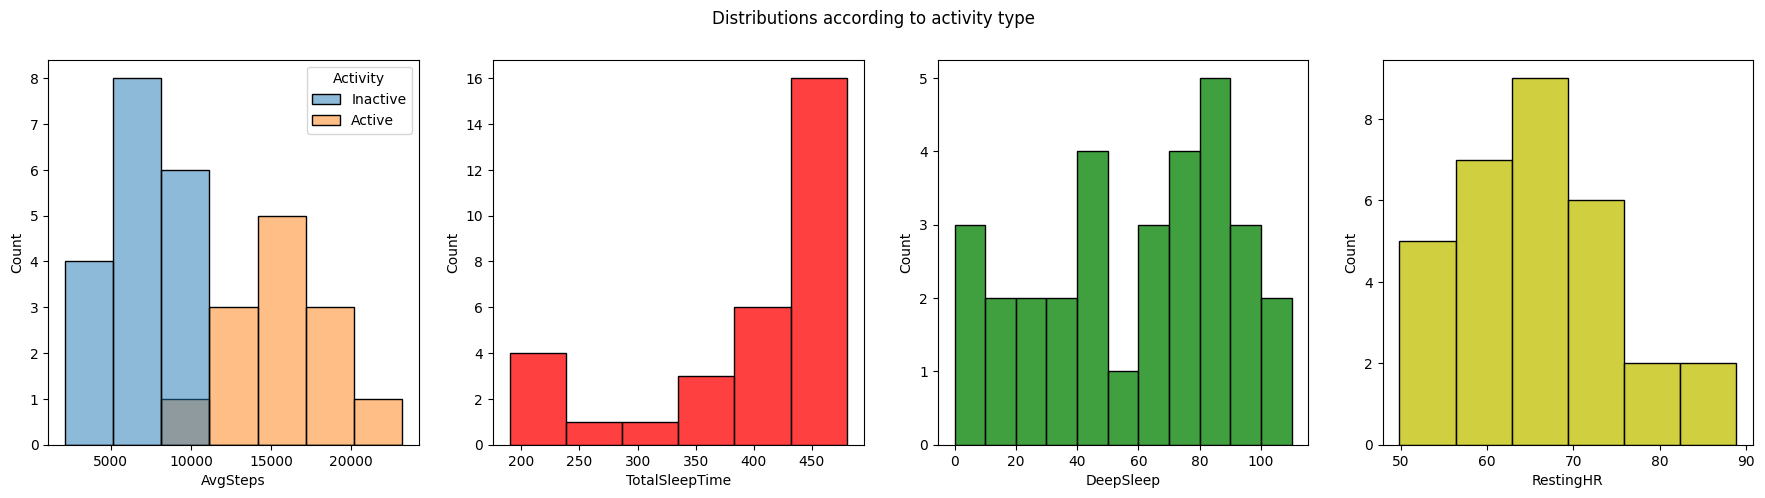

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(22, 5))
fig.suptitle('Distributions according to activity type')

sns.histplot(data = activity_df, x = 'AvgSteps', ax = axes[0], binwidth=3000, hue='Activity')

sns.histplot(data = activity_df, x = 'TotalSleepTime', ax = axes[1], binwidth=45, color='r')

sns.histplot(data = activity_df, x = 'DeepSleep', ax = axes[2], binwidth=10, color='g')

sns.histplot(data = activity_df, x = 'RestingHR', ax = axes[3], color='y')

plt.show()

Next, let us see the distribution of Active and Inactive subjects.

<Axes: xlabel='Activity', ylabel='Count'>

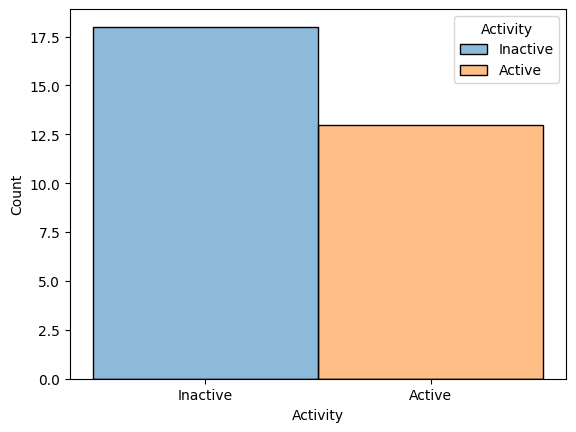

In [17]:
sns.histplot(data = activity_df, x = 'Activity', hue='Activity')

There are a few more Inactive subjects but not too many.

Let us see the distribution of deep sleep between the activity types in a violin plot.

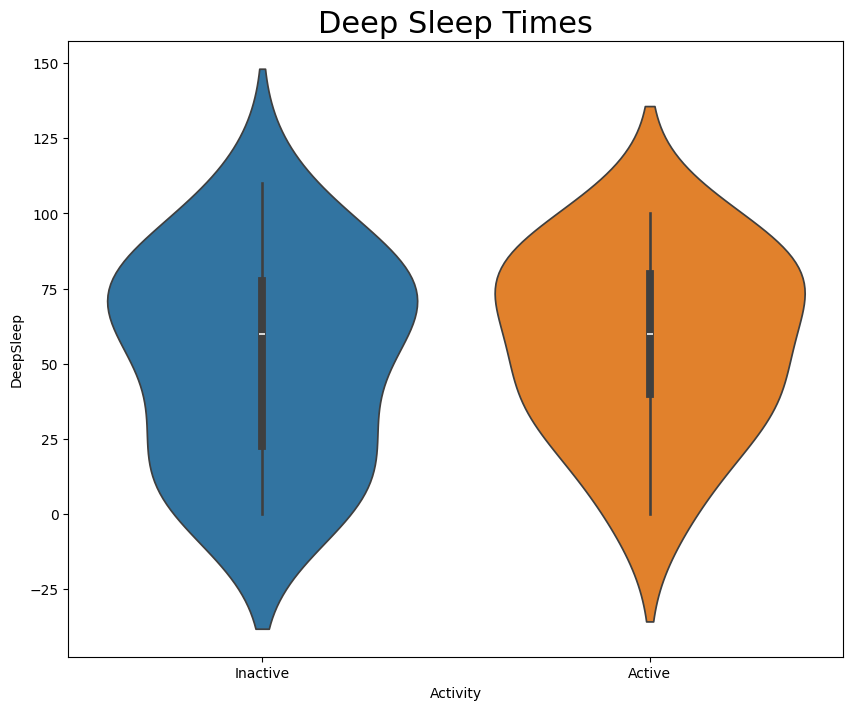

In [18]:
fig, axes = plt.subplots(1, figsize=(10, 8))

grid = plt.GridSpec(2, 3, wspace=0.2, hspace=0.5)

sns.violinplot(data=activity_df, x="Activity", y="DeepSleep", ax=axes, legend=False, hue='Activity')
axes.set_title("Deep Sleep Times", fontsize=22)


plt.show()

There is a slight difference between the activity types. The Inactive subjects get a lower amount of deep sleep compared to the Active subjects.

Let us plot the resting heart rate and average steps taken per day and see if there is a trend.

<Axes: xlabel='AvgSteps', ylabel='RestingHR'>

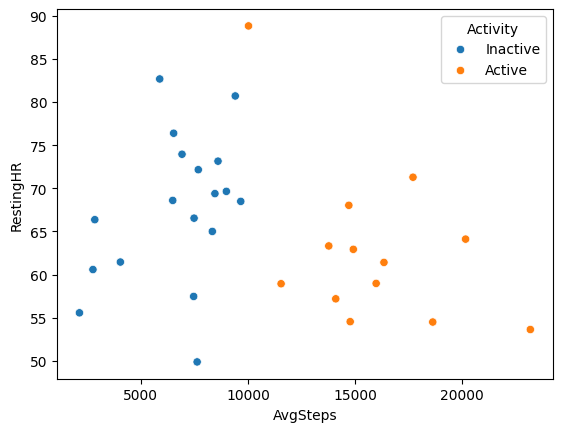

In [19]:
sns.scatterplot(data=activity_df, x="AvgSteps", y='RestingHR', hue='Activity') # add a space to x-axis label


It does seem like active subjects' resting heart rates are lower. Let us visualize that using jointplot and regression.

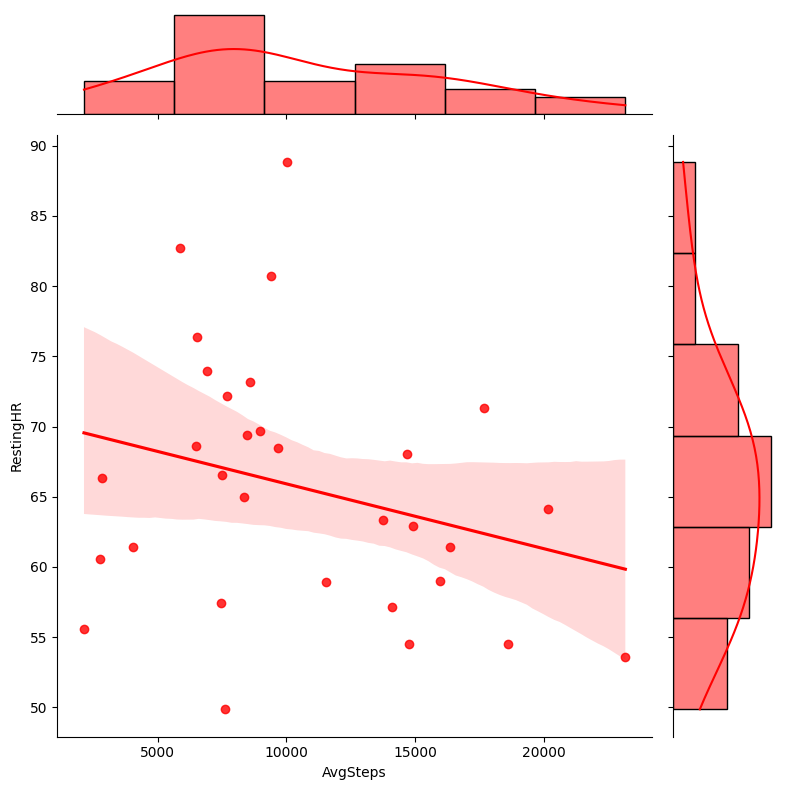

In [20]:
ax = sns.jointplot(data=activity_df,
              x="AvgSteps",
              y="RestingHR",
              kind="reg",
              height=8,
              color='r')

plt.show()

We can clearly see that the RestingHR is slightly lower for subjects whose average steps are higher, i.e. 'Active' subjects' resting heart rates are lower. This could imply that an active lifestyle results in lower resting heart rate, which reduces chances of cardiovascular diseases.

Let us visualize the dependency of steps taken and the amount of deep sleep slept and see if we can see a trend.

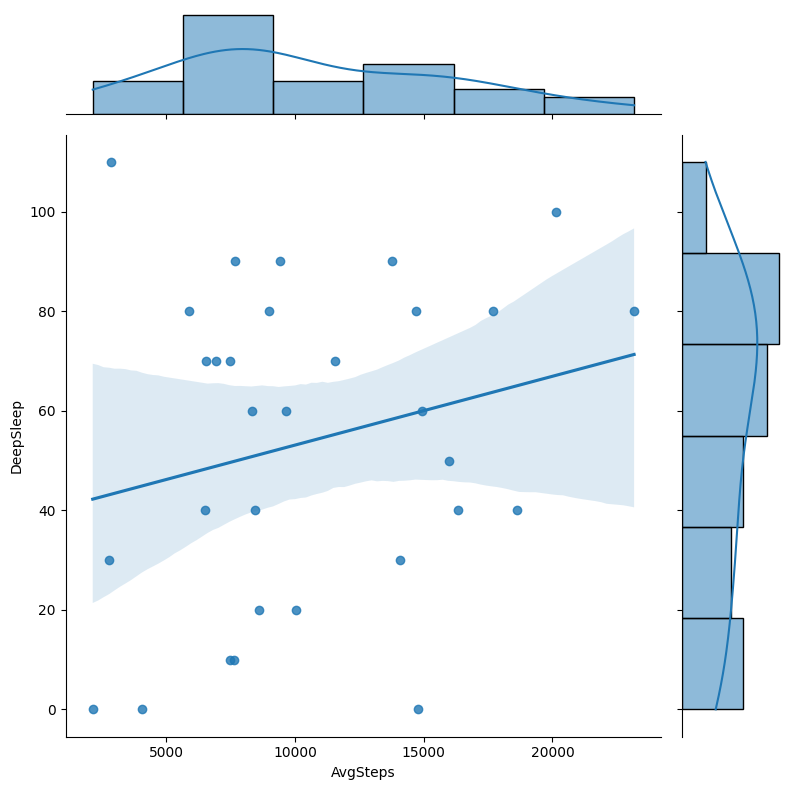

In [21]:
ax = sns.jointplot(data=activity_df,
              x="AvgSteps",
              y="DeepSleep",
              kind="reg",
              height=8)

plt.show()

There indeed is a clear trend visible. The more steps the subjects have taken, the longer the deep sleep phase during the night was. This could imply that an active lifestyle results in better sleep quality than an inactive lifestyle. 

## 3.2. Observation on Individual Level

In addition to group level observations, we will observe one subject and compare its results to the group average etc. I chose subject ID = 6220552 for this.

In [22]:
# Calculate the mean across the selected columns
columns_of_interest = ['Minutes', 'HeartRate', 'Steps', 'x', 'y', 'z']

# Calculate the mean heart rate for every minute, excluding zeros
average_df = df[df['HeartRate'] != 0].groupby('Minutes').agg({
    'HeartRate': 'mean',
    'Steps': 'mean',
    'x': 'mean',
    'y': 'mean',
    'z': 'mean'
}).reset_index()

# Define the most prominent stage
stage_counts = df.groupby(['Minutes', 'Stage']).size().reset_index(name='Count')
most_prominent_stage = stage_counts.loc[stage_counts.groupby('Minutes')['Count'].idxmax()]
average_df['Stage'] = most_prominent_stage['Stage']

# categorize as asleep or awake
average_df['Type'] = ['Awake' if value == 0 else 'Asleep' for value in average_df['Stage']]

average_df.head()

,Minutes,HeartRate,Steps,x,y,z,Stage,Type
0,-10070,73.250000,39.50,0.0,0.0,0.0,0.0,Awake
1,-10060,68.366667,4.40,0.0,0.0,0.0,0.0,Awake
2,-10050,71.250000,5.00,0.0,0.0,0.0,0.0,Awake
3,-10040,72.458333,8.75,0.0,0.0,0.0,0.0,Awake
4,-10030,58.375000,0.00,0.0,0.0,0.0,0.0,Awake


In [23]:
subject_id = 6220552  # subject of interest

In [24]:
# create data frame for our individual
all_data = df.groupby('ID')
subject_data = pd.DataFrame()
for id, value in all_data:
    if id == subject_id:
        subject_data = pd.DataFrame(value)

# create dataframe for our individual's activity
subject_activity = pd.DataFrame()
activities = activity_df.groupby('ID')
for id, value in activities:
    if id == subject_id:
        subject_activity = pd.DataFrame(value)

print(subject_activity)
subject_data.head()

         TotalSleepTime  TotalTimeInBed  DeepSleep      AvgSteps Activity  \
ID                                                                          
6220552             470             480      100.0  20150.285714   Active   

         RestingHR  
ID                  
6220552  64.107106  


,ID,Minutes,HeartRate,Stage,Steps,x,y,z,Type
1057,6220552,-10070,0.0,0,0.0,0.0,0.0,0.0,Awake
1058,6220552,-10060,0.0,0,0.0,0.0,0.0,0.0,Awake
1059,6220552,-10050,0.0,0,0.0,0.0,0.0,0.0,Awake
1060,6220552,-10040,0.0,0,0.0,0.0,0.0,0.0,Awake
1061,6220552,-10030,0.0,0,0.0,0.0,0.0,0.0,Awake


Next, I will visualize the steps distribution between the individual (blue) and the group average (orange). In addition, I will visualize the resting heart rate during the sleep study between individual and group average.

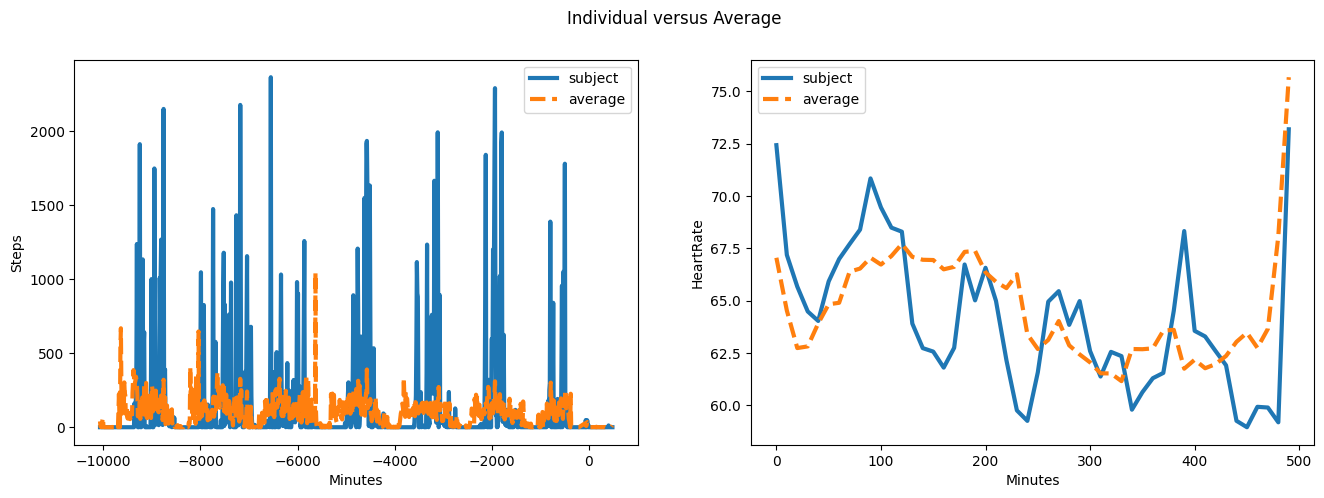

In [25]:
fig, ax = plt.subplots(1, 2,figsize=(16,5))

# steps distribution individual vs average
sns.lineplot(ax=ax[0], data=subject_data, x='Minutes', y='Steps', label="subject", linewidth=3)
sns.lineplot(ax=ax[0], data=average_df, x='Minutes', y='Steps', label="average", linewidth=3, linestyle="--")

# resting heart rate distribution individual vs average
sns.lineplot(ax=ax[1], data=subject_data[subject_data['Minutes']>=0], x='Minutes', y='HeartRate', label="subject", linewidth=3)
sns.lineplot(ax=ax[1], data=average_df[average_df['Minutes']>=0], x='Minutes', y='HeartRate', label="average", linewidth=3, linestyle="--")

fig.suptitle("Individual versus Average")

plt.show()


We can clearly see that the subject's steps are a lot higher, meaning that the subject is more active than average. The resting heart rate seems to be quite similar, although the subject has more variety. Next I will print out the amount of deep sleep, total sleep, average steps, and average resting heart rate between the individual and group average.

In [26]:
print("Group average Deep Sleep: ", activity_df['DeepSleep'].mean())
print("Individual Deep Sleep: ", subject_activity['DeepSleep'].mean())
print("Group average Resting HR: ", activity_df['RestingHR'].mean())
print("Individual Resting HR: ", subject_activity['RestingHR'].mean())
print("Group average Total Sleep Time: ", activity_df['TotalSleepTime'].mean())
print("Individual Total Sleep Time: ", subject_activity['TotalSleepTime'].mean())
print("Group average steps: ", activity_df['AvgSteps'].mean())
print("Individual average steps: ", subject_activity['AvgSteps'].mean())



Group average Deep Sleep:  53.87096774193548
Individual Deep Sleep:  100.0
Group average Resting HR:  65.66421852732668
Individual Resting HR:  64.107105667791
Group average Total Sleep Time:  400.96774193548384
Individual Total Sleep Time:  470.0
Group average steps:  10552.423963133644
Individual average steps:  20150.285714285714


# 4. Logistic Regression

In this part, I will use logistic regression model to conduct binary classification to see how well predictors heart rate and motion can predict whether the subject is Asleep or Awake. We'll start by importing the necessary libraries and initializing the classifier, scaler, and cross-validator objects.

I will use validation metrics to evaluate the performance of the model. I will be using Accuracy, Precision, Recall, and F1-score.

Since we are only interested in the sleep statics, we can take the data from 'Minutes' >= 0 onwards.


In [27]:
predictors = ["HeartRate", "x", "y", "z"]
target = "Type"
sleep_data = df[df['Minutes'] >= 0]
sleep_data.head()

,ID,Minutes,HeartRate,Stage,Steps,x,y,z,Type
1007,8000685,0,71.982143,0,0.0,-0.022420,0.000757,-0.862136,Awake
1008,8000685,10,70.715517,2,0.0,0.198307,0.051662,-0.954653,Asleep
1009,8000685,20,70.205128,2,0.0,0.128367,0.359673,-0.899428,Asleep
1010,8000685,30,70.146552,2,0.0,0.001238,0.654199,-0.722723,Asleep
1011,8000685,40,65.948276,2,0.0,-0.520685,0.750043,-0.316390,Asleep


In [28]:
# import necessary libraries

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [29]:
# initialize classifier, scaler, and cross-validation

clf = LogisticRegression(random_state=0)
scaler = StandardScaler()
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [30]:
# Prepare the predictors
X = sleep_data[predictors]

# Initialize lists for the results
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

# Prepare the target data, i.e., the Type
y = sleep_data[target]

# Loop through each fold in stratified k-fold
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scale the train and test data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Fit the scaled data
    clf_fit = clf.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = clf_fit.predict(X_test_scaled)

    # Calculate the evaluation metrics with 'Asleep' as positive label
    accuracy_list.append(accuracy_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred, zero_division=0, pos_label='Asleep'))
    recall_list.append(recall_score(y_test, y_pred, pos_label='Asleep'))
    f1_list.append(f1_score(y_test, y_pred, zero_division=0, pos_label='Asleep'))
    
# average metrics
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Target': [target],
    'Accuracy': [avg_accuracy],
    'Precision': [avg_precision],
    'Recall': [avg_recall],
    'F1 Score': [avg_f1]
})

In [31]:
results_df.head()

,Target,Accuracy,Precision,Recall,F1 Score
0,Type,0.894194,0.884245,0.999197,0.938138


Let's analyze the results:

1. **Average Accuracy: 89.61%**
   - The accuracy represents the proportion of correctly classified instances out of the total instances. With an accuracy of 89.61%, the model is correct about the sleep state nearly 90% of the time.

2. **Average Precision: 88.63%**
   - Precision is the proportion of true positive predictions out of all positive predictions. A precision of 88.63% indicates that when the model predicts 'Asleep,' it is correct about 88.63% of the time.

3. **Average Recall: 99.92%**
   - Recall (Sensitivity or True Positive Rate) is the proportion of actual positives that were correctly predicted by the model. A recall of 99.92% suggests that the model captures nearly all instances that are actually 'Asleep.'

4. **Average F1 Score: 93.93%**
   - The F1 score is the harmonic mean of precision and recall. An F1 score of 93.93% indicates a good balance between precision and recall.

**Considerations:**
- The high recall indicates that the model is effective at capturing instances that are truly 'Asleep.' 
- The precision, while slightly lower than recall, is still reasonably high, suggesting that the model is accurate when it predicts 'Asleep.'
- The high F1 score reinforces the good balance between precision and recall.

In summary, the model seems to perform well, especially in correctly identifying instances that are 'Asleep.' 


Let us visualize he confusion matrix for type Asleep.

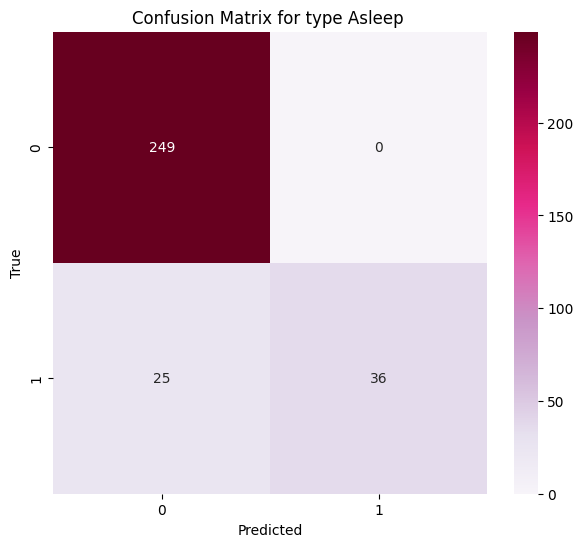

In [32]:
# Compute and display the confusion matrix for type 'Asleep'
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='PuRd')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for type Asleep ')
plt.show()